国土地理院の浸水域JSONから標高ラスターを生成。パラメータ調整可能。（必要手続き：Driveの接続）

JSONはダウンロードしてケース名のディレクトリに保存
./PLATEAU-FloodSAR/ケース名/

ケース名は衛星解析のものとは別にすること。（コンタミ防止）


In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title パラメータの設定
#casename = "kurume-r2-GIAJ"
casename = "omuta-r2-giaj"

mindepth = 0.05 # assume minimal depth of water to be detected
maxdem = 300 # maximum dem assumed for water surface. set something unrealy high.

flag_renew = False # Set True if flood_pts.pkl has been updated.

#flood_json = "chikugo_20200709.geojson" # ケースディレクトリ内のファイル名のみ。次のブロックにてフルパスに変換されます。
flood_json = "shinsui_rinkaku_omutashi.geojson"

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch
wall_height = 1000

analysis_tilesize = 4

errordem = -1000

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
file_bbox = path_case + "boundbox.npy"
file_fldbbox = path_case + "floodprb_bbox.npy"

file_flooddem = path_case + "flood_dem_{0:04d}.npz"
file_flooddepth = path_case + "flood_depth_{0:04d}.npz"

# 標高データの基本パラメータ
demtile_len = 256

flood_json = path_case + flood_json

In [ ]:
# @title 主要ライブラリインポート
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import requests
import os
import cv2
from scipy import ndimage as ndi
from progressbar import progressbar
from sklearn.ensemble import IsolationForest
from shapely import box
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [ ]:
# @title 領域の読み込み
boundbox = np.load(file_bbox)
print(boundbox)

[130.38311   32.991771 130.545845  33.103334]


## 国土地理院の標高データの取得

In [ ]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()
lons = tile["lons"]
lats = tile["lats"]
demmap = tile["dem"]

[130.38311   32.991771 130.545845  33.103334]
POLYGON ((130.545845 32.991771, 130.545845 33.103334, 130.38311 33.103334, 130.38311 32.991771, 130.545845 32.991771))


100% (16 of 16) |########################| Elapsed Time: 0:01:32 Time:  0:01:32


In [ ]:
np.save(file_fldbbox , boundbox)

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely.geometry import shape, mapping
import rasterio
from rasterio.features import geometry_mask

import json

with open(flood_json, "r") as f:
  geojson = json.load(f)


# 各ポリゴンを処理してマルチポリゴンジオメトリを作成します。
polygons = [shape(feature["geometry"]) for feature in geojson["features"]]

# マルチポリゴンのバウンディングボックスを取得します。
minx, miny, maxx, maxy = lons.min(), lats.min(), lons.max(), lats.max()
# ラスタライズのパラメータを設定します。

raster_height, raster_width = demmap.shape

transform = rasterio.transform.from_origin(minx, maxy, (maxx-minx)/raster_width, (maxy-miny)/raster_height)

# ラスタライズ
with rasterio.MemoryFile() as memfile:
    with memfile.open(driver='GTiff',
                      height=raster_height,
                      width=raster_width,
                      count=1,
                      dtype='uint8',
                      crs=geojson["crs"]["properties"]["name"],
                      transform=transform) as dataset:

        # 穴があるポリゴンを正しく処理するために、各ポリゴンを個別にマスクに変換し、
        # 結果を論理和で結合します。
        masks = []
        combined_mask = np.empty((raster_height, raster_width))
        combined_mask[:] = np.nan
        for poly in polygons:
            mask = geometry_mask([mapping(poly)],
                                 transform=dataset.transform,
                                 invert=True,
                                 out_shape=(dataset.height, dataset.width))
            if mask.max():
              combined_mask[mask] = np.nanmax(demmap[mask])
            del mask

(130.374755859375, 130.55049419403076, 32.99021715139026, 33.109893770453134)

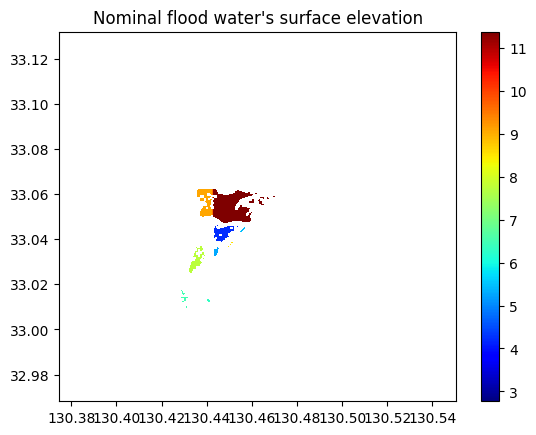

In [ ]:
ax = plt.subplot()
plt.imshow(combined_mask, cmap="jet", extent=[minx, maxx, miny, maxy])

ax.set_xlim(boundbox[0], boundbox[2])
ax.set_ylim(boundbox[1], boundbox[3])
plt.colorbar()

plt.title("Nominal flood water's surface elevation")
ax.axis('equal')

(130.374755859375, 130.55049419403076, 32.99021715139026, 33.109893770453134)

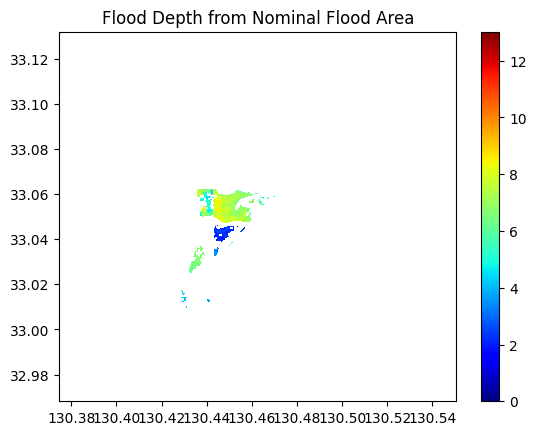

In [ ]:
ax = plt.subplot()

plt.imshow(combined_mask - demmap, cmap="jet", extent=[minx, maxx, miny, maxy])

ax.set_xlim(boundbox[0], boundbox[2])
ax.set_ylim(boundbox[1], boundbox[3])
plt.colorbar()

plt.title("Flood Depth from Nominal Flood Area")
ax.axis('equal')

In [ ]:
maxdepth = 0 # np.nanmax(combined_mask-demmap)

In [ ]:
np.savez(file_flooddem.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_dem=combined_mask)
np.savez(file_flooddepth.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_depth=combined_mask-demmap)